In [54]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

In [59]:
# Specify Model
reduced = True
model_type = 'keras' # keras or h5 or onnx
factor_index = 0

# Load Model    

In [56]:
# Load the model
model_url = '../models/fitmotion_model'
if reduced:
    model_url += '_reduced'

if model_type == 'keras':
    model = keras.models.load_model(model_url + '.keras')
elif model_type == 'h5':
    model = tf.keras.models.load_model(model_url + '.h5')
elif model_type == 'onnx':
    import onnx
    import onnxruntime as ort
    sess = ort.InferenceSession(model_url + '.onnx')


labels = ['dws', 'jog', 'sit', 'std', 'ups', 'wlk']

# Loading The Data

### Native Android Data

In [14]:
# Load Android Data
data_source = 'android_data_latest'
if reduced:
    data_source += '_reduced'
data_type = 'wlk'
data_num = '1'
data_url = '../data/' + data_source + '/' + data_type + '/' + data_type + data_num + '-SensorData.csv'

df = pd.read_csv(data_url, sep=',')
    
df = df.drop(['Unnamed: 0'], axis=1) if 'Unnamed: 0' in df.columns else df
df = df.drop(['id'], axis=1) if 'id' in df.columns else df
df

,Gravity X,Gravity Y,Gravity Z,User Acceleration X,User Acceleration Y,User Acceleration Z
0,3.159663,-9.276977,-0.353036,-0.049377,0.006249,-0.018233
1,3.159663,-9.276977,-0.353036,-0.049377,0.006249,-0.018233
2,3.154015,-9.278942,-0.351873,-0.058250,-0.017869,-0.075712
3,3.154015,-9.278942,-0.351873,-0.058250,-0.017869,-0.075712
4,3.154015,-9.278942,-0.351873,-0.058250,-0.017869,-0.075712
...,...,...,...,...,...,...
1528,2.671978,-9.414862,0.625539,-0.000979,0.020016,-0.159608
1529,2.671978,-9.414862,0.625539,-0.000979,0.020016,-0.159608
1530,2.671978,-9.414862,0.625539,-0.000979,0.020016,-0.159608
1531,2.671978,-9.414862,0.625539,-0.000979,0.020016,-0.159608


### Web Data

In [57]:
# Load Android Data
data_source = 'html_data_reduced' if reduced else 'html_data'
device_source = 'iphone'
data_type = 'sit'
data_num = '1'

data_url = '../data/' + data_source + '/' + device_source + '/' + data_type + '/' + data_type + '_' + data_num + '.csv'

df = pd.read_csv(data_url, sep=',')
df = df.drop(['Unnamed: 0'], axis=1) if 'Unnamed: 0' in df.columns else df
df = df.drop(['id'], axis=1) if 'id' in df.columns else df
df = df.drop(['Timestamp'], axis=1) if 'Timestamp' in df.columns else df
df

,Gravity X,Gravity Y,Gravity Z,User Acceleration X,User Acceleration Y,User Acceleration Z
0,-6.28,-2.72,-6.30,0.00,0.32,0.60
1,-6.45,-2.97,-6.45,-0.16,0.10,0.42
2,-6.28,-2.97,-6.72,0.01,0.15,0.12
3,-6.36,-3.19,-7.45,-0.02,-0.04,-0.67
4,-6.70,-4.13,-7.57,-0.29,-0.95,-0.87
...,...,...,...,...,...,...
2096,-1.45,-5.70,-7.76,-0.06,0.15,-0.02
2097,-1.94,-5.75,-7.09,-0.57,0.09,0.67
2098,-1.68,-6.04,-7.58,-0.31,-0.20,0.18
2099,-1.52,-5.91,-7.87,-0.17,-0.09,-0.10


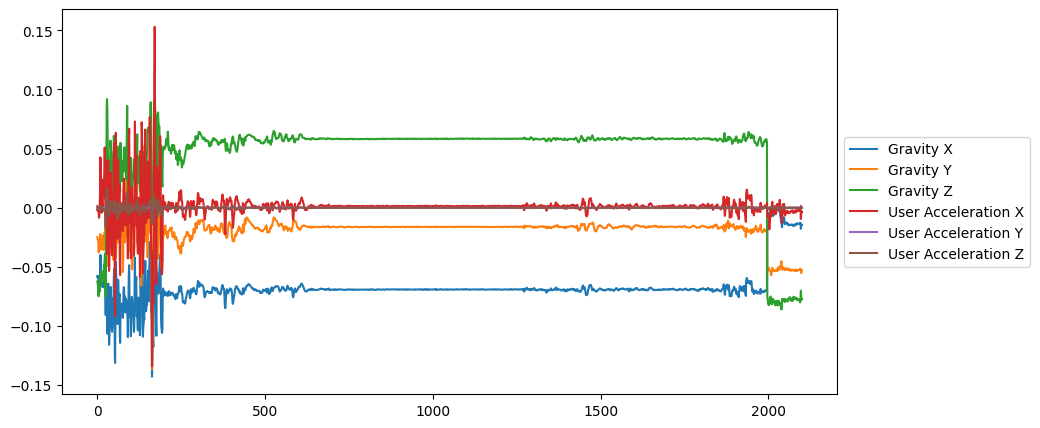

In [47]:
# Check Data by Plotting
plt.figure(figsize=(10, 5))
plt.plot(df)
plt.legend(df.columns, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [48]:
# Remove Noise Data
df = df.iloc[200:1600]

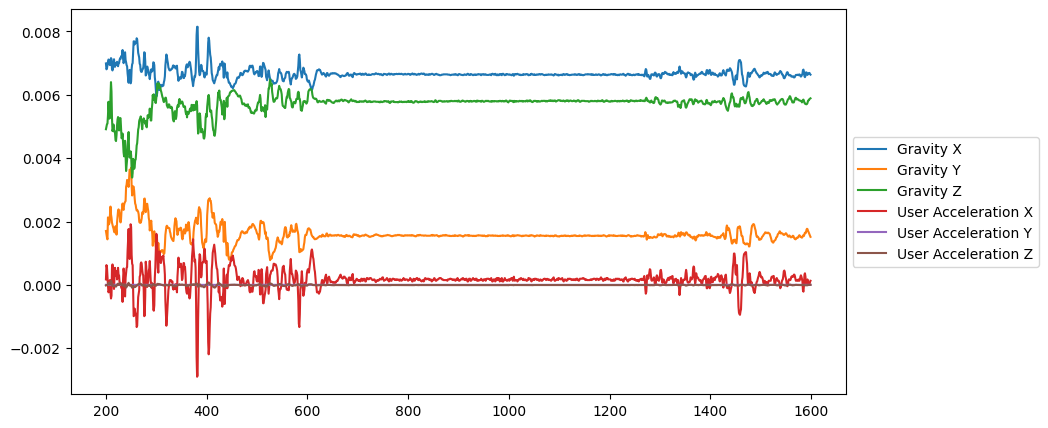

In [53]:
# Check Data by Plotting
plt.figure(figsize=(10, 5))
plt.plot(df)
plt.legend(df.columns, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Original Data

In [60]:
# Load Orignal Data (for comparison)
data_source_o = 'dataset'
if reduced:
    data_source_o += '_reduced'
data_type_o = 'sit_5'
data_num_o = '1'
data_url_o = '../data/' + data_source_o + '/' + data_type_o + '/' + 'sub_' + data_num_o + '.csv'

df_o = pd.read_csv(data_url_o)
df_o = df_o.drop(['Unnamed: 0'], axis=1) if 'Unnamed: 0' in df_o.columns else df_o
df_o

,gravity.x,gravity.y,gravity.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,0.314588,0.404381,-0.858784,0.000094,0.000252,-0.006954
1,0.314649,0.404445,-0.858732,-0.001309,0.002262,-0.010348
2,0.314567,0.404560,-0.858708,-0.002174,0.000012,-0.006664
3,0.314286,0.404740,-0.858726,0.001693,0.009216,-0.011575
4,0.314271,0.404894,-0.858658,0.005767,0.007490,-0.008926
...,...,...,...,...,...,...
10287,0.344357,0.358687,-0.867619,0.000004,0.007707,-0.003506
10288,0.343920,0.359324,-0.867528,-0.002688,0.006063,0.003011
10289,0.343255,0.360411,-0.867341,0.001548,0.019090,-0.007339
10290,0.342652,0.360835,-0.867403,0.004180,0.016942,-0.019789


In [61]:
# opening scaling factor file to read the dictionary
constants_url = '../constants_reduced.txt' if reduced else '../constants.txt'

factors = []
with open(constants_url, 'r') as f:
    lines = f.readlines()
    for line in lines:
        factors.append(eval(line))
factors

[{'Gravity X': -0.029265712404529493,
  'Gravity Y': -0.22722004698950246,
  'Gravity Z': -0.15057012495325492,
  'User Acceleration X': 0.005179955652958614,
  'User Acceleration Y': 0.0062933435697516815,
  'User Acceleration Z': 0.03198073759345864}]

In [62]:
# Multiply data with constants
for i in range(len(df.columns)):
    df.iloc[:, i] = df.iloc[:, i] * factors[factor_index][df.columns[i]]

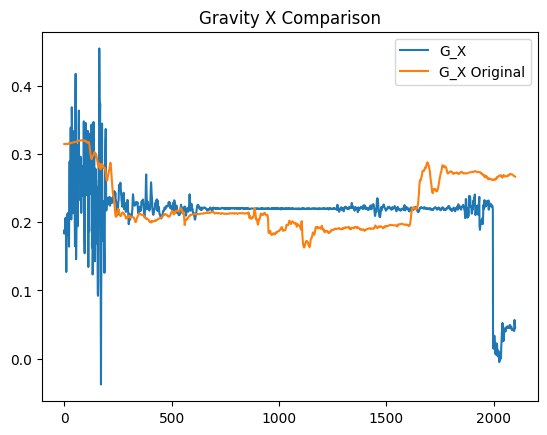

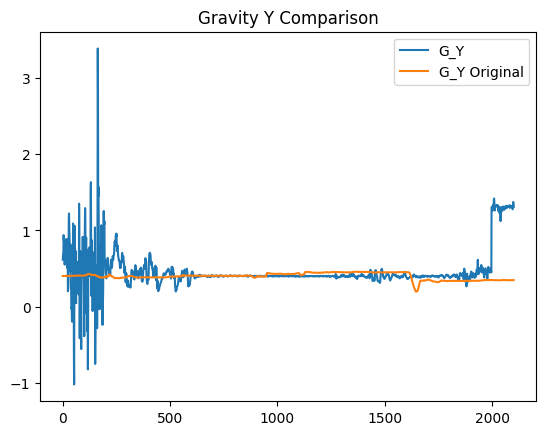

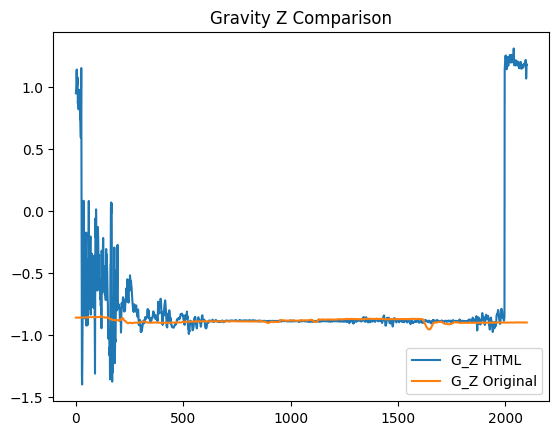

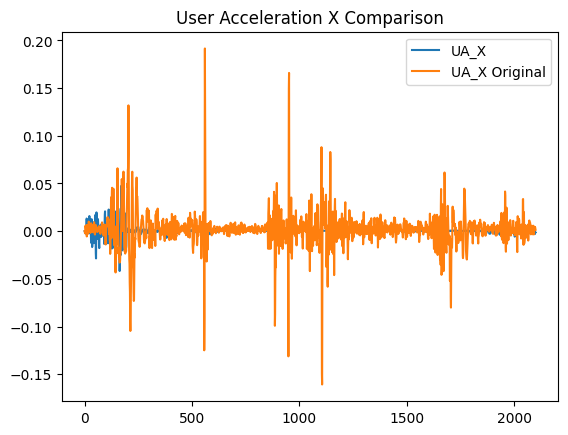

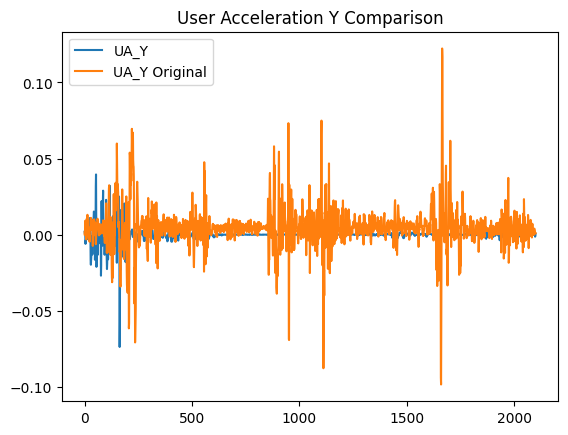

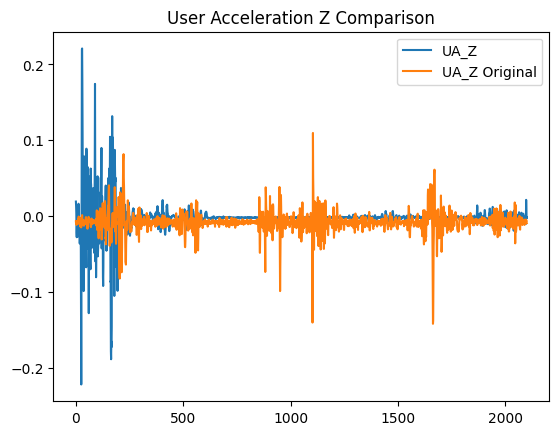

In [63]:
# Check Data Similiraties
plt.title('Gravity X Comparison')
plt.plot(df['Gravity X'], label='G_X')
plt.plot(df_o['gravity.x'].iloc[0:len(df)], label='G_X Original')
plt.legend()
plt.show()

plt.title('Gravity Y Comparison')
plt.plot(df['Gravity Y'], label='G_Y')
plt.plot(df_o['gravity.y'].iloc[0:len(df)], label='G_Y Original')
plt.legend()
plt.show()

plt.title('Gravity Z Comparison')
plt.plot(df['Gravity Z'], label='G_Z HTML')
plt.plot(df_o['gravity.z'].iloc[0:len(df)], label='G_Z Original')
plt.legend()
plt.show()

plt.title('User Acceleration X Comparison')
plt.plot(df['User Acceleration X'], label='UA_X')
plt.plot(df_o['userAcceleration.x'].iloc[0:len(df)], label='UA_X Original')
plt.legend()
plt.show()

plt.title('User Acceleration Y Comparison')
plt.plot(df['User Acceleration Y'], label='UA_Y')
plt.plot(df_o['userAcceleration.y'].iloc[0:len(df)], label='UA_Y Original')
plt.legend()
plt.show()

plt.title('User Acceleration Z Comparison')
plt.plot(df['User Acceleration Z'], label='UA_Z')
plt.plot(df_o['userAcceleration.z'].iloc[0:len(df)], label='UA_Z Original')
plt.legend()
plt.show()

# Preprocessing Data

In [64]:
# Prepare the data
WINDOW_LENGTH = 150
STRIDE_LENGTH = 10
NUM_CLASSES = 6 if reduced else 12
NUM_FEATURES = 12
BATCH_SIZE = 100
EPOCHS_SIZE = 10

In [65]:
from scipy.stats import mode

def sequence_generator(x, length, stride):
    seq_x = []
    data_length = len(x)

    for i in range(0, data_length - length + 1, stride):
        input_sequence = x.iloc[i : i + length]
        seq_x.append(input_sequence)
    return np.array(seq_x)

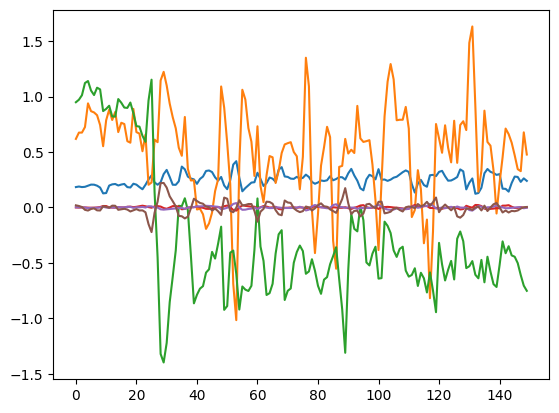

In [68]:
# Checking data
import matplotlib.pyplot as plt

tx = sequence_generator(df, WINDOW_LENGTH, STRIDE_LENGTH)
plt.plot(tx[0])
plt.show()

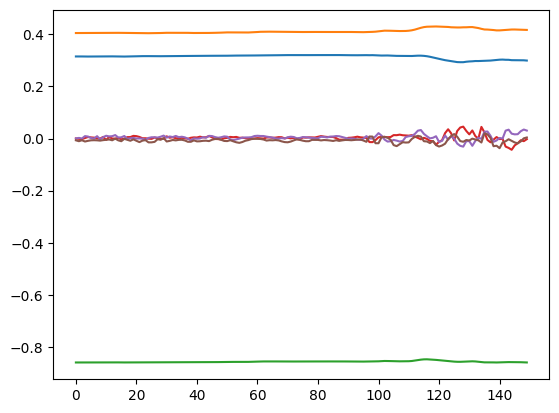

In [67]:
txc = sequence_generator(df_o, WINDOW_LENGTH, STRIDE_LENGTH)
plt.plot(txc[0])
plt.show()

# Prediction

In [69]:
if model_type == 'onnx':
    # Predict with ONNX
    tx = tx.astype(np.float32)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name
    y_pred = sess.run([output_name], {input_name: tx})[0]
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = mode(y_pred)[0]
else: 
    # Predict the data
    y_pred = model.predict(tx)

    # Get the most frequent label
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = mode(y_pred)[0]

print(labels[y_pred])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
sit
